Mounted at /content/drive
    Returns
0 -0.087318
1  0.300101
2  0.170977
3  0.097033
4  0.050209
                      TIMESTAMP      OPEN      HIGH       LOW     CLOSE
INDEX                                                                  
0     2023-01-02 09:16:00+05:30  43135.40  43151.25  43097.20  43118.30
10    2023-01-02 09:26:00+05:30  43079.55  43086.25  43018.85  43018.85
20    2023-01-02 09:36:00+05:30  43148.80  43194.00  43144.55  43192.90
30    2023-01-02 09:46:00+05:30  43257.00  43284.30  43247.25  43284.30
40    2023-01-02 09:56:00+05:30  43322.30  43332.20  43306.25  43318.50


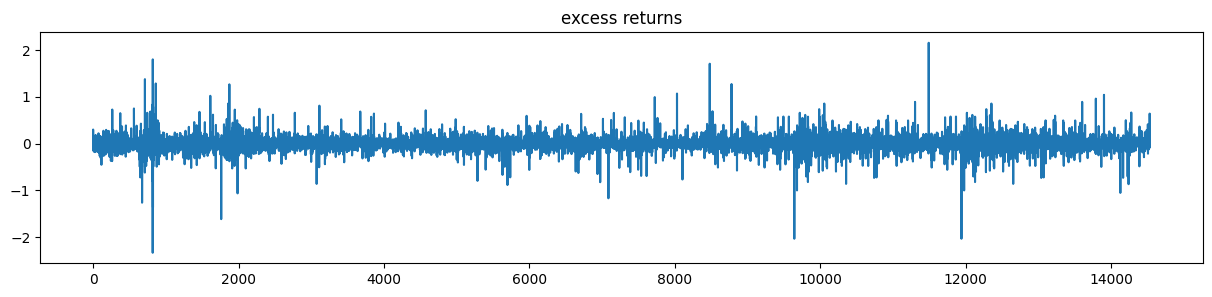

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

drive.mount('/content/drive', force_remount=True)

# Load the data
banknifty = pd.read_csv('/content/drive/My Drive/banknifty.csv', index_col=0)  # Adjust index_col appropriately


# Convert the TIMESTAMP column to datetime
banknifty['TIMESTAMP'] = pd.to_datetime(banknifty['TIMESTAMP'])  # Adjust the format if needed


# Set the TIMESTAMP as the index
banknifty=banknifty.drop(columns='DIR')
banknifty=banknifty.drop(columns='LABEL')

banknifty2 = banknifty.copy()

banknifty2.set_index('TIMESTAMP', inplace=True)

# # Resample and compute changes to get returns for last n minute period
# banknifty_ret = banknifty2.resample('10T', offset='6min').last().pct_change().dropna() //OLD WRONG VERSION

# # banknifty_ret.index = banknifty_ret.index + pd.DateOffset(days=0, hours=0, minutes=9)
# banknifty.set_index('INDEX', inplace=True)

rows_per_period = 10

#Group by every 'rows_per_period' rows and take the last one in each group
# banknifty_ret = banknifty.groupby(banknifty.index // rows_per_period).last().pct_change().dropna()

# Group by every 'rows_per_period' rows and use .nth(0) for the first and .nth(-1) for the last row in each group
banknifty_first = banknifty.groupby(banknifty.index // rows_per_period).nth(0)
banknifty_last = banknifty.groupby(banknifty.index // rows_per_period).nth(-1)

# banknifty_pct_change = ((banknifty_last - banknifty_first) / banknifty_first) * 100

# Pre-allocate a list and then create the DataFrame from the list
percentage_changes = []

# Loop through data
for i in range(len(banknifty_first)):
    pct_change = ((banknifty_last.iloc[i]['CLOSE'] - banknifty_first.iloc[i]['CLOSE']) / banknifty_first.iloc[i]['CLOSE']) * 100
    percentage_changes.append(pct_change)

# Convert list to DataFrame
returns = pd.DataFrame(percentage_changes, columns=['Returns'])

# Display DataFrame
print(returns.head())
print(banknifty_first.head())
# print(banknifty_ret.head())
# print(banknifty_ret.iloc[70:80])

# Plot the results
# banknifty_ret['CLOSE'].iloc[:100].plot(title='excess returns', figsize=(15, 3), legend=False)
returns.plot(title='excess returns', figsize=(15, 3), legend=False)
# banknifty_ret.plot(title='excess returns', figsize=(15, 3), legend=False)


plt.show()

# banknifty




In [ ]:
# import pandas as pd

# # Resample data to weekly, taking the last observation as representative
# banknifty_tenmin = banknifty.resample('10t', offset='6min').last()

# # If your original data starts on a non-standard weekday or time, adjust the timestamp manually
# # Here, adding an offset to align with the end of a period
# banknifty_tenmin.index = banknifty_tenmin.index + pd.DateOffset(days=0, hours=0, minutes=9)

# # Proceed with calculation of returns
# #banknifty_ret = banknifty_tenmin.pct_change().dropna()

# print(banknifty_tenmin.iloc[:10])

# print(percentage_changes_df.head())
# print(banknifty_ret.head())

In [ ]:
#Run AD Fuller test; if P value is close to 0, the time series is relatively stationary and model can be fit on it
# adfuller(banknifty_ret.dropna()['CLOSE'])
adfuller(returns.dropna())

(-48.304281810697894,
 0.0,
 5,
 14526,
 {'1%': -3.4308002585680533,
  '5%': -2.861738994332033,
  '10%': -2.5668759199626456},
 -15821.107824295108)

In [2]:
#Fit the model
mod_kns = sm.tsa.MarkovRegression(returns.dropna(), k_regimes=3, trend='n', switching_variance=True)

# mod_kns = sm.tsa.MarkovAutoregression(returns.dropna(), k_regimes=4, trend='n', switching_variance=True)


#https://www.statsmodels.org/devel/examples/notebooks/generated/markov_autoregression.html

res_kns = mod_kns.fit()
res_kns.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                Returns   No. Observations:                14532
Model:               MarkovRegression   Log Likelihood               11466.009
Date:                Mon, 10 Jun 2024   AIC                         -22914.018
Time:                        23:21:33   BIC                         -22845.761
Sample:                             0   HQIC                        -22891.336
                              - 14532                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0036      0.000     23.914      0.000       0.003       0.004
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0163      0.001     20.394      0.000       0.015       0.018
                             Regime 2 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.1964      0.016     11.983      0.000       0.164       0.229
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9075      0.008    117.919      0.000       0.892       0.923
p[1->0]        0.0917      0.010      9.257      0.000       0.072       0.111
p[2->0]        0.0163      0.032      0.515      0.607      -0.046       0.079
p[0->1]        0.0747      0.009      8.485      0.000       0.057       0.092
p[1->1]        0.8511      0.012     70.637      0.000       0.827       0.875
p[2->1]        0.6604      0.059     11.150      0.000       0.544       0.776
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [ ]:
# #original order: Low, Medium, High
# #low variance associated with bull, high variance associated with bear market

# fig, axes = plt.subplots(4, figsize=(10,7))  # Create 4 subplots


# # Loop through each regime
# for i in range(3):
#     ax = axes[i]
#     ax.plot(res_kns.filtered_marginal_probabilities[i])
#     ax.set(title=f'Smoothed probability of regime {i} for stock returns')

# ax = axes[3]
# ax.plot(returns, label='Excess Returns', color='red', alpha=0.5)  #Plot returns on the same axes
# ax.set(title=f'Excess Returns')


# fig.tight_layout()
# # returns.plot(title='excess returns', figsize=(15, 7), legend=False)

# plt.show()


In [ ]:
# fig, axes = plt.subplots(4, figsize=(10,7))
# ax = axes[0]
# ax.plot(res_kns.smoothed_marginal_probabilities[0])
# ax.set(title='Smoothed probability of a low-variance regime for stock returns')
# ax = axes[1]
# ax.plot(res_kns.smoothed_marginal_probabilities[1])
# ax.set(title='Smoothed probability of a medium-variance regime for stock returns')
# ax = axes[2]
# ax.plot(res_kns.smoothed_marginal_probabilities[2])
# ax.set(title='Smoothed probability of a high-variance regime for stock returns')

# ax = axes[3]
# ax.plot(returns, label='Excess Returns', color='red', alpha=0.5)  #Plot returns on the same axes
# ax.set(title=f'Excess Returns')

# fig.tight_layout()
# plt.show()

In [3]:
# print(res_kns.smoothed_marginal_probabilities)
# print(banknifty_first['TIMESTAMP'])
# print(len(percentage_changes))


# Create an empty DataFrame
combined_data = pd.DataFrame()

# Add data to the DataFrame
combined_data['Timestamp'] = banknifty_first['TIMESTAMP']
combined_data['Low_Variance_Prob'] = res_kns.smoothed_marginal_probabilities[0].values
combined_data['Medium_Variance_Prob'] = res_kns.smoothed_marginal_probabilities[1].values
combined_data['High_Variance_Prob'] = res_kns.smoothed_marginal_probabilities[2].values
combined_data['Returns'] = percentage_changes  # 'percentage_changes' is a list of equal length

# print(combined_data.head())

daily_groups = combined_data.copy()
daily_groups['Timestamp'] = pd.to_datetime(combined_data['Timestamp'])

# Set the 'Timestamp' column as the DataFrame's index
combined_data.set_index('Timestamp', inplace=True)

print(combined_data)

#Split data into daily groups for charts
daily_groups = daily_groups.groupby(combined_data.index.date)
print(daily_groups)

# daily_groups_df.set_index('Timestamp', inplace=True)

# print(daily_groups_df.columns)

                           Low_Variance_Prob  Medium_Variance_Prob  \
Timestamp                                                            
2023-01-02 09:16:00+05:30       1.018971e-01              0.841840   
2023-01-02 09:26:00+05:30       1.427422e-05              0.762038   
2023-01-02 09:36:00+05:30       6.682128e-03              0.918135   
2023-01-02 09:46:00+05:30       8.624369e-02              0.888150   
2023-01-02 09:56:00+05:30       1.784300e-01              0.805025   
...                                      ...                   ...   
2024-04-30 13:45:00+05:30       5.204571e-01              0.379946   
2024-04-30 13:55:00+05:30       2.141178e-22              0.000408   
2024-04-30 14:05:00+05:30       7.841090e-02              0.833846   
2024-04-30 14:15:00+05:30       2.879704e-01              0.694395   
2024-04-30 14:25:00+05:30       3.726557e-01              0.611851   

                           High_Variance_Prob   Returns  
Timestamp                      

In [ ]:
# import matplotlib.pyplot as plt

# # Loop through each group and plot
# for date, group in daily_groups:
#     fig, axes = plt.subplots(4, 1, figsize=(10, 10), sharex=True)
#     titles = ['Low Variance Probability', 'Medium Variance Probability', 'High Variance Probability', 'Returns']
#     data_keys = ['Low_Variance_Prob', 'Medium_Variance_Prob', 'High_Variance_Prob', 'Returns']

#     for i, ax in enumerate(axes):
#         ax.plot(group.index, group[data_keys[i]], label=titles[i])
#         ax.set_title(f'{titles[i]} on {date}')
#         ax.legend()
#         ax.set_xlabel('Time')
#         ax.set_ylabel('Value')

#     plt.tight_layout()
#     plt.show()

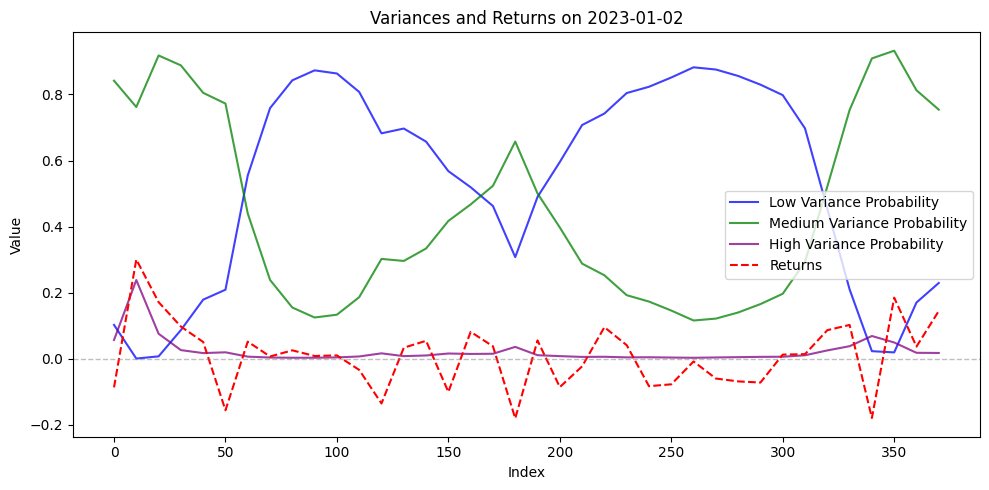

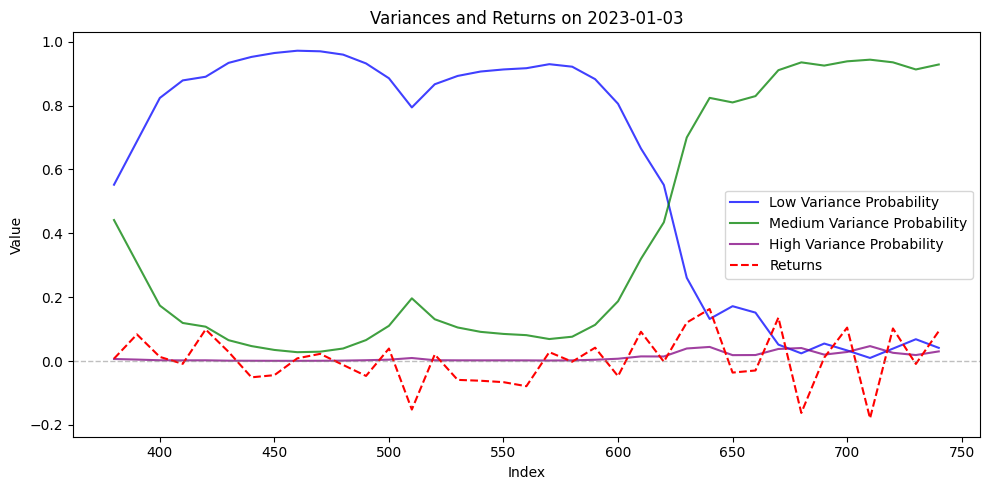

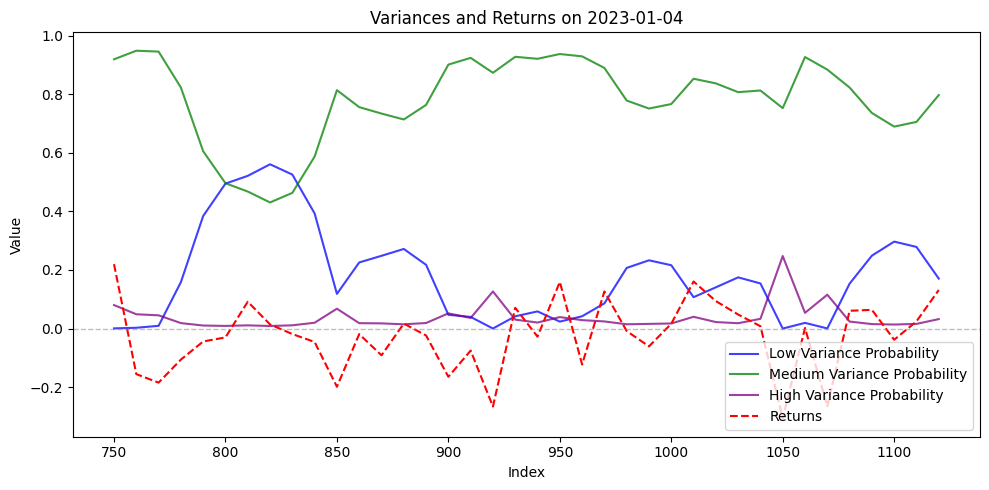

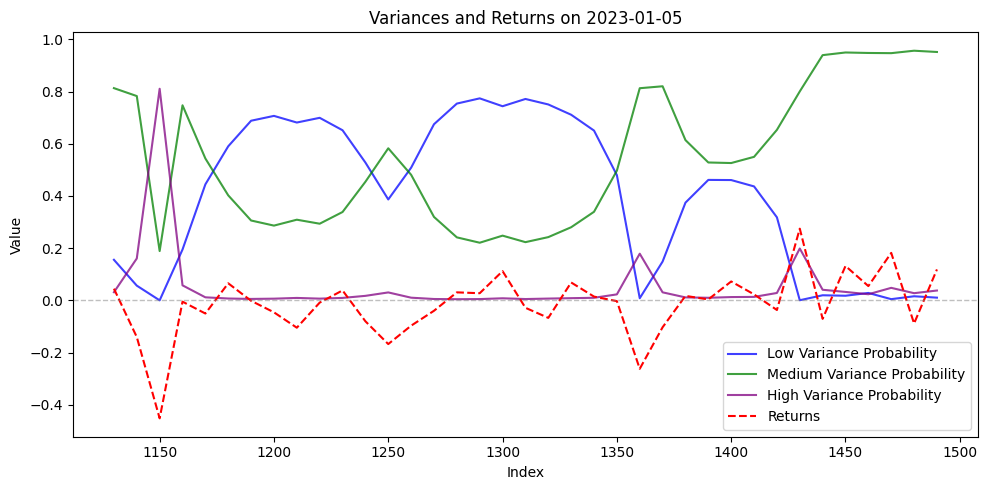

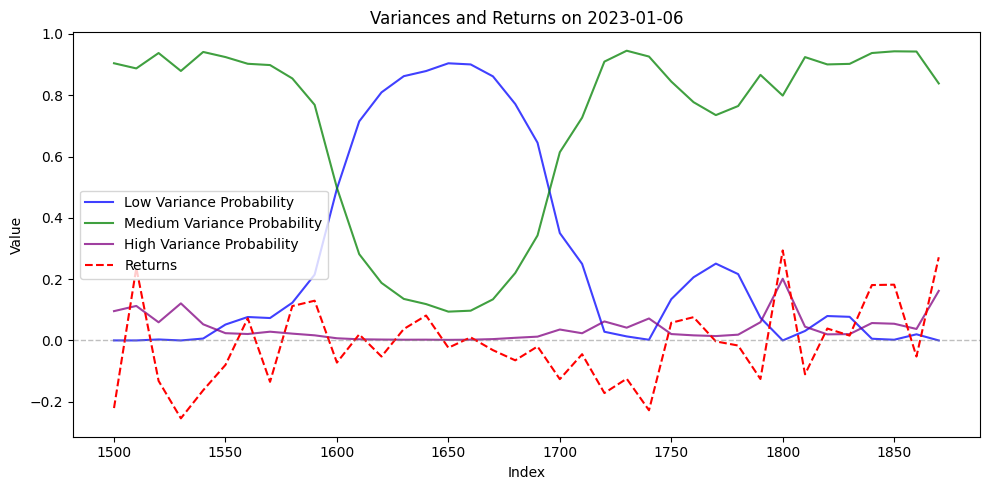

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

# Loop through each group and plot
for date, group in daily_groups:
    fig, ax = plt.subplots(figsize=(10, 5))
    titles = ['Low Variance Probability', 'Medium Variance Probability', 'High Variance Probability', 'Returns']
    data_keys = ['Low_Variance_Prob', 'Medium_Variance_Prob', 'High_Variance_Prob', 'Returns']
    colors = ['blue', 'green', 'purple', 'red']  # Colors for different data keys
    linestyles = ['-', '-', '-', '--']  # Line styles for different data keys
    alphas = [0.75, 0.75, 0.75, 1]  # Transparency levels

    for i, key in enumerate(data_keys):
        ax.plot(group.index, group[key], label=titles[i], color=colors[i], linestyle=linestyles[i], alpha=alphas[i])

    # Adding a horizontal line at y=0
    ax.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)

    ax.set_title(f'Variances and Returns on {date}')
    ax.legend()
    ax.set_xlabel('Index')
    ax.set_ylabel('Value')
    plt.tight_layout()
    plt.show()


In [4]:
low_var = list(res_kns.smoothed_marginal_probabilities[0])
med_var = list(res_kns.smoothed_marginal_probabilities[1])
high_var = list(res_kns.smoothed_marginal_probabilities[2])

regime_list = []
for i in range(len(low_var)):
    if low_var[i] > med_var[i] and low_var[i] > high_var[i]:
        regime_list.append(0)  # Low variance regime
    elif med_var[i] > high_var[i]:
        regime_list.append(1)  # Medium variance regime
    else:
        regime_list.append(2)  # High variance regime

# Iterate through banknifty close prices; color regimes based on whichever probability is highest.

combined_data['Regime_pred'] = regime_list
combined_data

,Low_Variance_Prob,Medium_Variance_Prob,High_Variance_Prob,Returns,Regime_pred
Timestamp,,,,,
2023-01-02 09:16:00+05:30,1.018971e-01,0.841840,0.056263,-0.087318,1
2023-01-02 09:26:00+05:30,1.427422e-05,0.762038,0.237948,0.300101,1
2023-01-02 09:36:00+05:30,6.682128e-03,0.918135,0.075183,0.170977,1
2023-01-02 09:46:00+05:30,8.624369e-02,0.888150,0.025606,0.097033,1
2023-01-02 09:56:00+05:30,1.784300e-01,0.805025,0.016545,0.050209,1
...,...,...,...,...,...
2024-04-30 13:45:00+05:30,5.204571e-01,0.379946,0.099597,-0.081440,0
2024-04-30 13:55:00+05:30,2.141178e-22,0.000408,0.999592,0.640608,2
2024-04-30 14:05:00+05:30,7.841090e-02,0.833846,0.087743,0.056329,1


In [ ]:
# import matplotlib.pyplot as plt
# import pandas as pd

# # Assuming both dataframes are indexed by datetime and are sorted
# # Set the initial color
# current_color = "blue"  # Default color

# fig, ax = plt.subplots(figsize=(12, 6))

# # Iterate through the banknifty DataFrame
# for timestamp, row in banknifty.iterrows():
#     # Check if the current timestamp exists in combined_data
#     if timestamp in combined_data.index:
#         # Change the color based on the regime
#         regime = combined_data.loc[timestamp, 'Regime']
#         if regime == 0:
#             current_color = "green"  # Example color for regime 0
#         elif regime == 1:
#             current_color = "red"   # Example color for regime 1
#         elif regime == 2:
#             current_color = "purple"  # Example color for regime 2

#     # Plot the current point with the current color
#     # ax.scatter(timestamp, row['CLOSE'], color=current_color)

# ax.set_title('Bank Nifty Close Prices with Color-Coded Regimes')
# ax.set_xlabel('Timestamp')
# ax.set_ylabel('Close Price')
# plt.show()


In [7]:
import pandas as pd

# Assuming 'banknifty' is your DataFrame and it's indexed by datetime
# Group by 10-minute intervals and calculate standard deviation
# banknifty2.set_index('TIMESTAMP', inplace=True)

std_devs = banknifty2['CLOSE'].resample('60T').std()

# # Merge the standard deviations back to the original dataframe to compare each close price against its group's standard deviation
# banknifty2.drop('key_0', axis=1, inplace=True)
banknifty2 = banknifty2.merge(std_devs.rename('StdDev'), left_on=banknifty2.index.floor('60T'), right_index=True)

# banknifty2.set_index('TIMESTAMP', inplace=True)


# Function to determine the variance category
def variance_category(close, mean, stddev):
    deviations = abs(close - mean) / stddev
    if deviations <= 1:
        return 0
    elif deviations <= 1.5:
        return 1
    elif deviations <= 2:
        return 2
    else:
        return 2  # More than 2 standard deviations

# Calculate mean prices for the 60-minute intervals
mean_prices = banknifty2['CLOSE'].resample('60T').mean()

# Add mean prices to banknifty DataFrame for calculation
banknifty2['Mean'] = banknifty2.index.map(mean_prices)

#Apply the variance category function
banknifty2['true_var'] = banknifty2.apply(lambda row: variance_category(row['CLOSE'], row['Mean'], row['StdDev']), axis=1)

# print(banknifty2[['CLOSE', 'StdDev', 'Mean', 'true_var']].head(70))


ValueError: cannot insert key_0, already exists

In [24]:
import pandas as pd

# Assuming you have two DataFrames named df1 and df2

# First, ensure that the 'Timestamp' columns in both dataframes are of datetime type
banknifty2.reset_index(inplace=True)
combined_data.reset_index(inplace=True)

# Convert the 'Timestamp' columns to datetime format
banknifty2['TIMESTAMP'] = pd.to_datetime(banknifty2['TIMESTAMP'])
combined_data['TIMESTAMP'] = pd.to_datetime(combined_data['Timestamp'])

# Merge the dataframes on the 'Timestamp' column using an inner join
merged_df = pd.merge(banknifty2, combined_data, on='TIMESTAMP', how='inner', suffixes=('_1', '_2'))

# Assume 'Regime_pred' is the column for regime prediction in both dataframes
# You might need to adjust these column names based on your actual dataframe structure

# print(banknifty2.head())
# print(combined_data.head())



ValueError: cannot insert level_0, already exists

In [27]:
print(merged_df.head())

merged_df['Match'] = merged_df['true_var'] == merged_df['Regime_pred']

# Calculate the accuracy as the number of matches over the total number of entries in the merged dataframe
accuracy = merged_df['Match'].mean() * 100

print(f"Accuracy: {accuracy:.2f}%")

   level_0_1  index_1                 TIMESTAMP                     key_0  \
0          0        0 2023-01-02 09:16:00+05:30 2023-01-02 09:00:00+05:30   
1         10       10 2023-01-02 09:26:00+05:30 2023-01-02 09:00:00+05:30   
2         20       20 2023-01-02 09:36:00+05:30 2023-01-02 09:00:00+05:30   
3         30       30 2023-01-02 09:46:00+05:30 2023-01-02 09:00:00+05:30   
4         40       40 2023-01-02 09:56:00+05:30 2023-01-02 09:00:00+05:30   

       OPEN      HIGH       LOW     CLOSE      StdDev  Mean  true_var  \
0  43135.40  43151.25  43097.20  43118.30  118.266548   NaN         2   
1  43079.55  43086.25  43018.85  43018.85  118.266548   NaN         2   
2  43148.80  43194.00  43144.55  43192.90  118.266548   NaN         2   
3  43257.00  43284.30  43247.25  43284.30  118.266548   NaN         2   
4  43322.30  43332.20  43306.25  43318.50  118.266548   NaN         2   

   level_0_2  index_2                 Timestamp  Low_Variance_Prob  \
0          0        0 2023-0

In [23]:
# banknifty2

# import matplotlib.pyplot as plt

# # Assuming 'banknifty2' contains 'Close' prices and a 'true_var' column for variance categories
# # Define colors for each category in true_var
# colors = {0: 'green', 1: 'blue', 2: 'red'}

# # Create a figure and axis for plotting
# fig, ax = plt.subplots(figsize=(10, 6))

# # Group data by 'true_var' and plot each group with a specific color
# for category, group in banknifty2.groupby('true_var'):
#     ax.scatter(group.index, group['CLOSE'], color=colors[category], label=f'Var {category}', alpha=0.5)

# ax.set_title('Close Prices Color Coded by Variance Regime')
# ax.set_xlabel('Timestamp')
# ax.set_ylabel('Close Price')
# ax.legend(title='Variance Category')

# plt.show()

print(merged_df.head())
print(len(merged_df))


   level_0_1  index_1                 TIMESTAMP                     key_0  \
0          0        0 2023-01-02 09:16:00+05:30 2023-01-02 09:00:00+05:30   
1         10       10 2023-01-02 09:26:00+05:30 2023-01-02 09:00:00+05:30   
2         20       20 2023-01-02 09:36:00+05:30 2023-01-02 09:00:00+05:30   
3         30       30 2023-01-02 09:46:00+05:30 2023-01-02 09:00:00+05:30   
4         40       40 2023-01-02 09:56:00+05:30 2023-01-02 09:00:00+05:30   

       OPEN      HIGH       LOW     CLOSE      StdDev  Mean  true_var  \
0  43135.40  43151.25  43097.20  43118.30  118.266548   NaN         2   
1  43079.55  43086.25  43018.85  43018.85  118.266548   NaN         2   
2  43148.80  43194.00  43144.55  43192.90  118.266548   NaN         2   
3  43257.00  43284.30  43247.25  43284.30  118.266548   NaN         2   
4  43322.30  43332.20  43306.25  43318.50  118.266548   NaN         2   

   level_0_2  index_2                 Timestamp  Low_Variance_Prob  \
0          0        0 2023-0